# Practical session n°7

Notions:
- Quantile regression
- Pinball Loss


Duration: 1 h 30

In this practical, we immerse ourselves again in the context where the training inputs ($x$) and targets ($y$) are images of the same spatial dimensions. However, we assume that the dependence of $y$ on $x$ is probabilistic in nature. In other words, there exist conditional laws $p(y | x)$, and these laws need to be characterized.

Here, we limit ourselves to conditional marginals, meaning the laws $p(y_{i,j} | x)$ where $y_{i,j}$ represents the value of the target $y$ at the pixel $(i,j)$. To characterize these laws, several approaches are possible. For instance, one can attempt to estimate their quantiles or moments. The following exercises illustrate a method for estimating quantiles.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms

In [2]:
! git clone https://github.com/nanopiero/ML_S5_etudiants
import sys
sys.path.append('ML_S5_etudiants/practicals/P7')
from utils_P7 import gen_proba, voir_batch2D, UNet

Cloning into 'ML_S5_etudiants'...
remote: Enumerating objects: 368, done.
remote: Counting objects: 100% (200/200), done.
remote: Compressing objects: 100% (151/151), done.
remote: Total 368 (delta 108), reused 88 (delta 45), pack-reused 168 (from 2)
Receiving objects: 100% (368/368), 20.12 MiB | 25.50 MiB/s, done.
Resolving deltas: 100% (152/152), done.


**Exercise 1**: on the PINBALL loss

As seen in the previous practical session n°4, using the Mean Absolute Error (MAE) led the model to provide the conditional median, which is a particular quantile. To estimate other quantiles, it is sufficient to modify the MAE.

This is what we are going to do on a simple problem where the link between the input and the target is defined by:
$$y_{i,j} \sim \mathcal{N}(\mu(x_{i,j}), \sigma(x_{i,j})) $$
where $\mu$ and $\sigma$ are a priori unknown.

The gen_proba function from the utile.py module will allow us to "explore" our dataset, or in other words, to sample the random pair $(x, y)$.

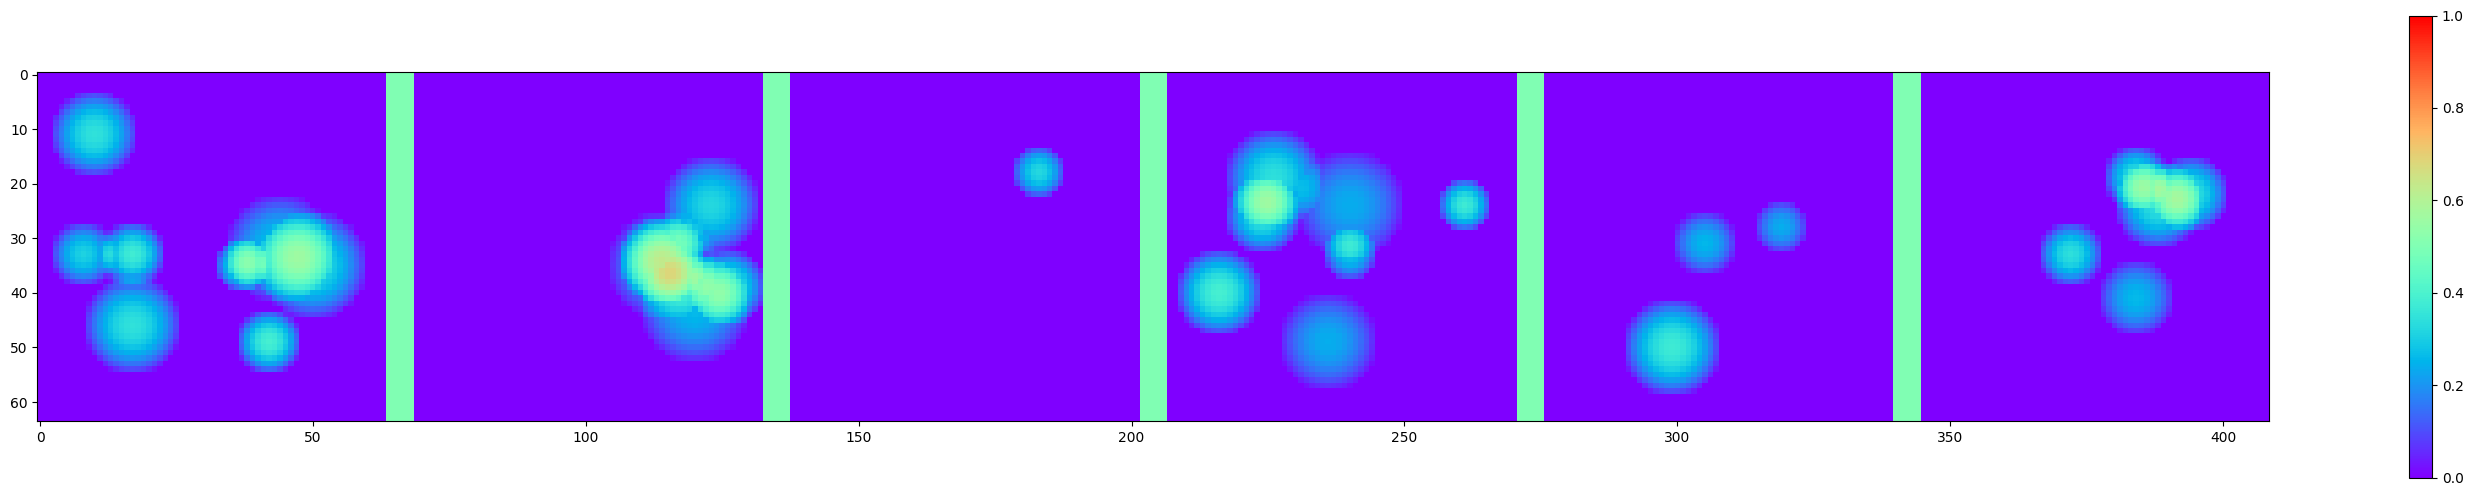

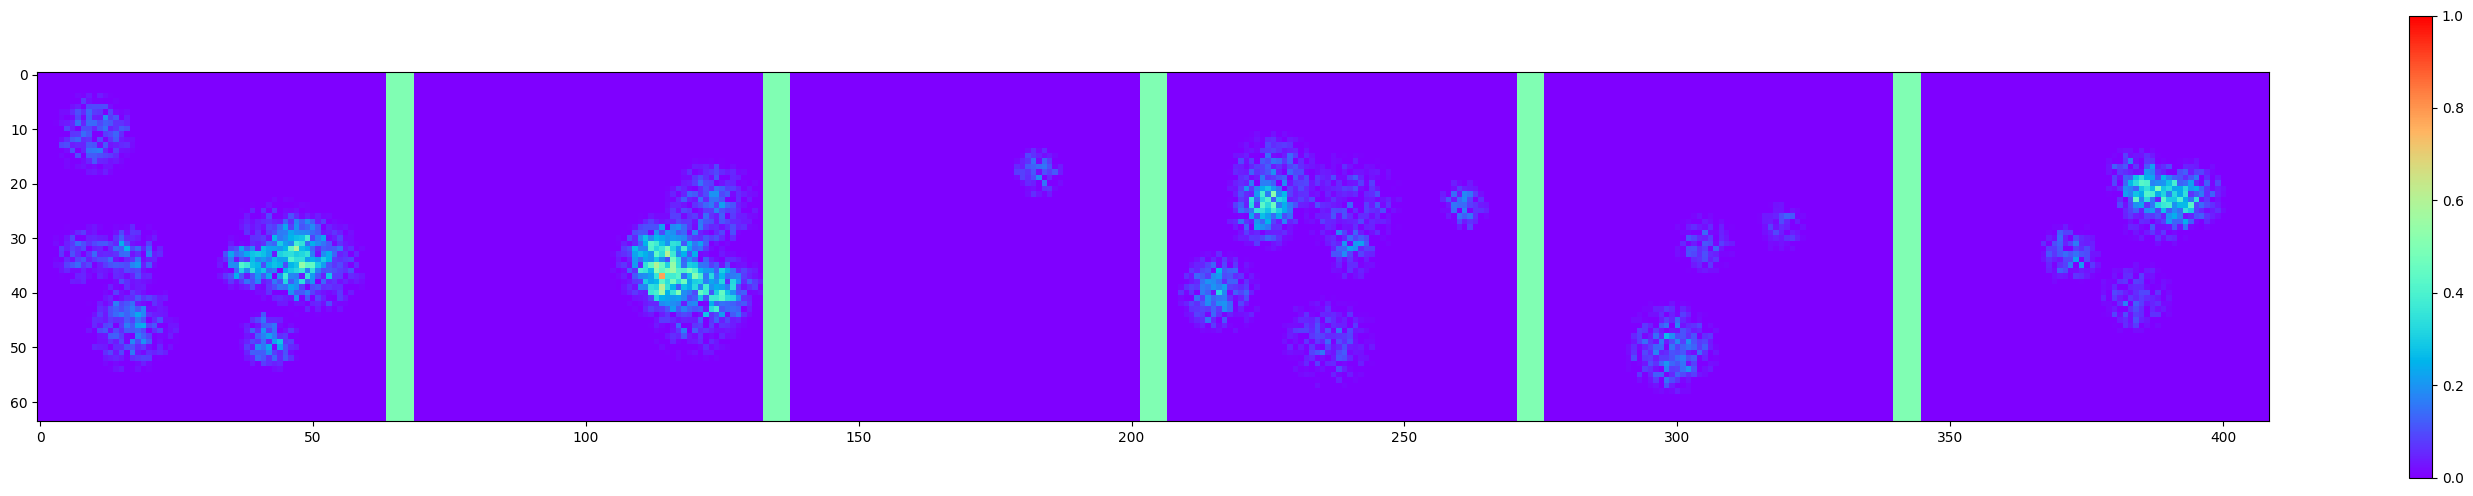

In [3]:
# sampling (x,y) :

input, target = gen_proba(6)
# Inputs
fig0 = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig0, k=0, min_scale=0,max_scale=1)

# Targets
fig1 = plt.figure(1, figsize=(36, 6))
voir_batch2D(target, 6, fig1, k=0, min_scale=0,max_scale=1)

Let's consider the cost function be defined at the pixel level by:
$$\mathcal{L}_t(y,z) =  \rho_t(z - y) $$  
where:
$$\rho_t(u) = t \times max(u,0) + (t-1) \times min(u,0) $$

**Q1** Plot the graph of $\rho_t$ for different values of $t$ in the range [0, 1] using *matplotlib.pyplot*.
How does $\mathcal{L}_t$ generalize the MAE?

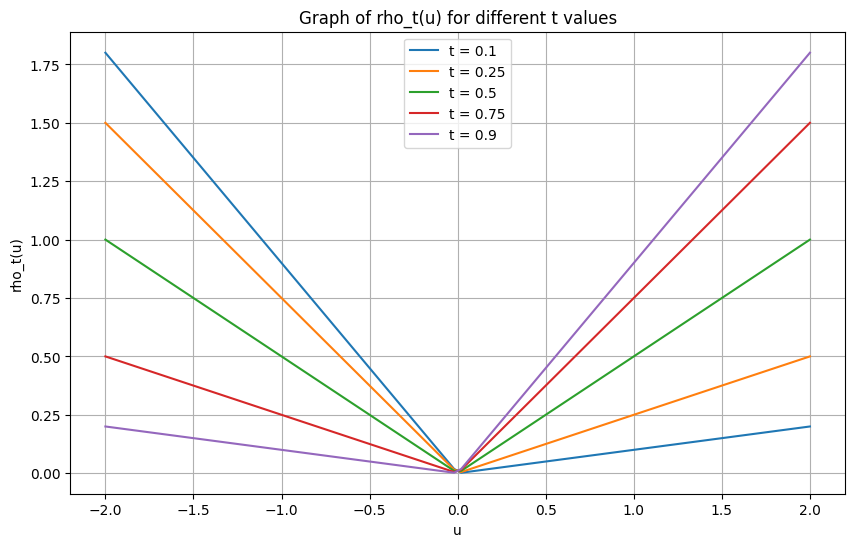

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def rho_t(u, t):
    return t * np.maximum(u, 0) + (t - 1) * np.minimum(u, 0)

u_values = np.linspace(-2, 2, 100)
t_values = [0.1, 0.25, 0.5, 0.75, 0.9]

plt.figure(figsize=(10, 6))
for t in t_values:
    rho_values = rho_t(u_values, t)
    plt.plot(u_values, rho_values, label=f't = {t}')

plt.xlabel('u')
plt.ylabel('rho_t(u)')
plt.title('Graph of rho_t(u) for different t values')
plt.grid(True)
plt.legend()
plt.show()

**Q2** In the following cell, code a cost function adapted to the estimation of $t$-th quantiles (use *.clamp*( ))

In [14]:
def rho(u, t):
    # u.clamp(min=0) garde la partie positive (équivalent à max(u, 0))
    # u.clamp(max=0) garde la partie négative (équivalent à min(u, 0))
    loss = t * u.clamp(min=0) + (t - 1) * u.clamp(max=0)
    return loss

**Q3** Train a U-Net to estimate the ninth decile.

In [15]:
def criterion(output, target):
  return torch.mean(rho(target - output, 0.9)) # For the ninth decile, t = 0.9. Added torch.mean()

In [7]:
fcn = UNet(1,1,8).cuda()
import torch.optim as optim
optimizer = optim.Adam(fcn.parameters(), 10**(-3))

In [16]:
nepochs = 50
nbatches = 100
batchsize = 64

train_losses = []

for epoch in range(nepochs):

    print("Epoch " + str(epoch))
    epoch_losses  = []
    for i in range(nbatches):

        # 1. Génération des données
        input, target = gen_proba(batchsize)
        input = input.cuda()
        target = target.cuda()

        # 2. Remise à zéro des gradients
        optimizer.zero_grad()

        # 3. Passage avant (Forward)
        output = fcn(input)

        # 4. Calcul de la perte
        loss = criterion(output, target)

        # 5. Rétropropagation (Backward) et mise à jour
        loss.backward()
        optimizer.step()

        # Stockage de la perte pour affichage
        epoch_losses.append(loss.item())

    epoch_loss = np.mean(epoch_losses)
    train_losses.append(epoch_loss)
    print('epoch loss : \n')
    print(epoch_loss)

Epoch 0
epoch loss : 

0.008215664275921882
Epoch 1
epoch loss : 

0.0036313613574020564
Epoch 2
epoch loss : 

0.002929816567339003
Epoch 3
epoch loss : 

0.0025456622696947307
Epoch 4
epoch loss : 

0.002271570764714852
Epoch 5
epoch loss : 

0.0022960414283443244
Epoch 6
epoch loss : 

0.0023070580279454587
Epoch 7
epoch loss : 

0.0022824024211149665
Epoch 8
epoch loss : 

0.002007400207221508
Epoch 9
epoch loss : 

0.002112853326834738
Epoch 10
epoch loss : 

0.002239176593720913
Epoch 11
epoch loss : 

0.0019037431024480612
Epoch 12
epoch loss : 

0.001942451192298904
Epoch 13
epoch loss : 

0.0020074696303345263
Epoch 14
epoch loss : 

0.0018212874815799296
Epoch 15
epoch loss : 

0.001945283142849803
Epoch 16
epoch loss : 

0.0018143182632047684
Epoch 17
epoch loss : 

0.001899778574006632
Epoch 18
epoch loss : 

0.0020475960115436463
Epoch 19
epoch loss : 

0.001767205714713782
Epoch 20
epoch loss : 

0.0018016856093890964
Epoch 21
epoch loss : 

0.0019691481895279138
Epoch 22

**Q4** The ground truth is given by:
$$ \mu(x_{i,j}) = {x}_{i,j}^2 $$
and
$$ \sigma(x_{i,j}) = 0.2 \times x_{i,j} $$

Use [torch.distributions.normal.Normal](https://pytorch.org/docs/stable/distributions.html) to verify that the result corresponds well to the expected quantile.

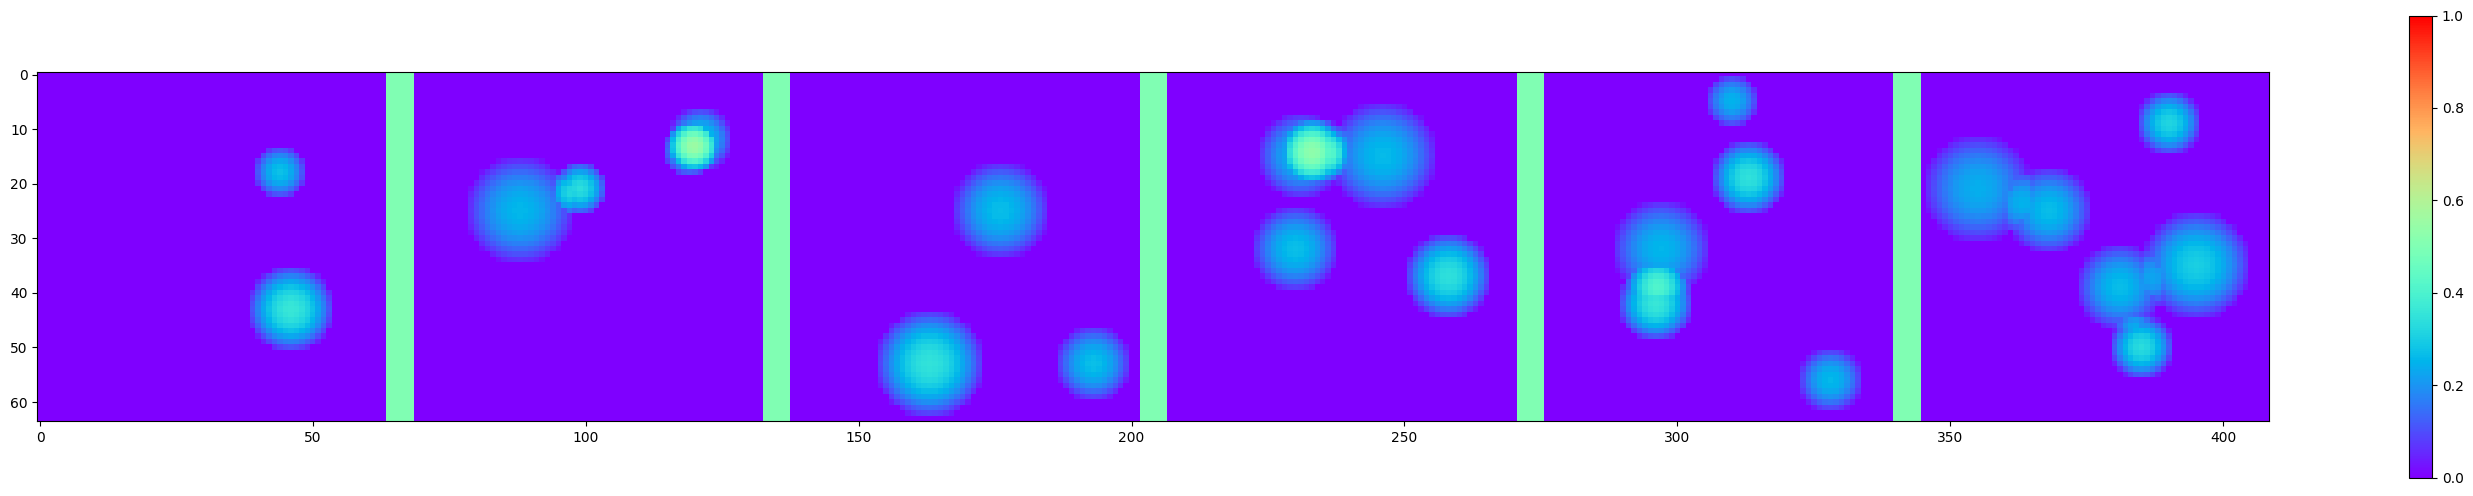

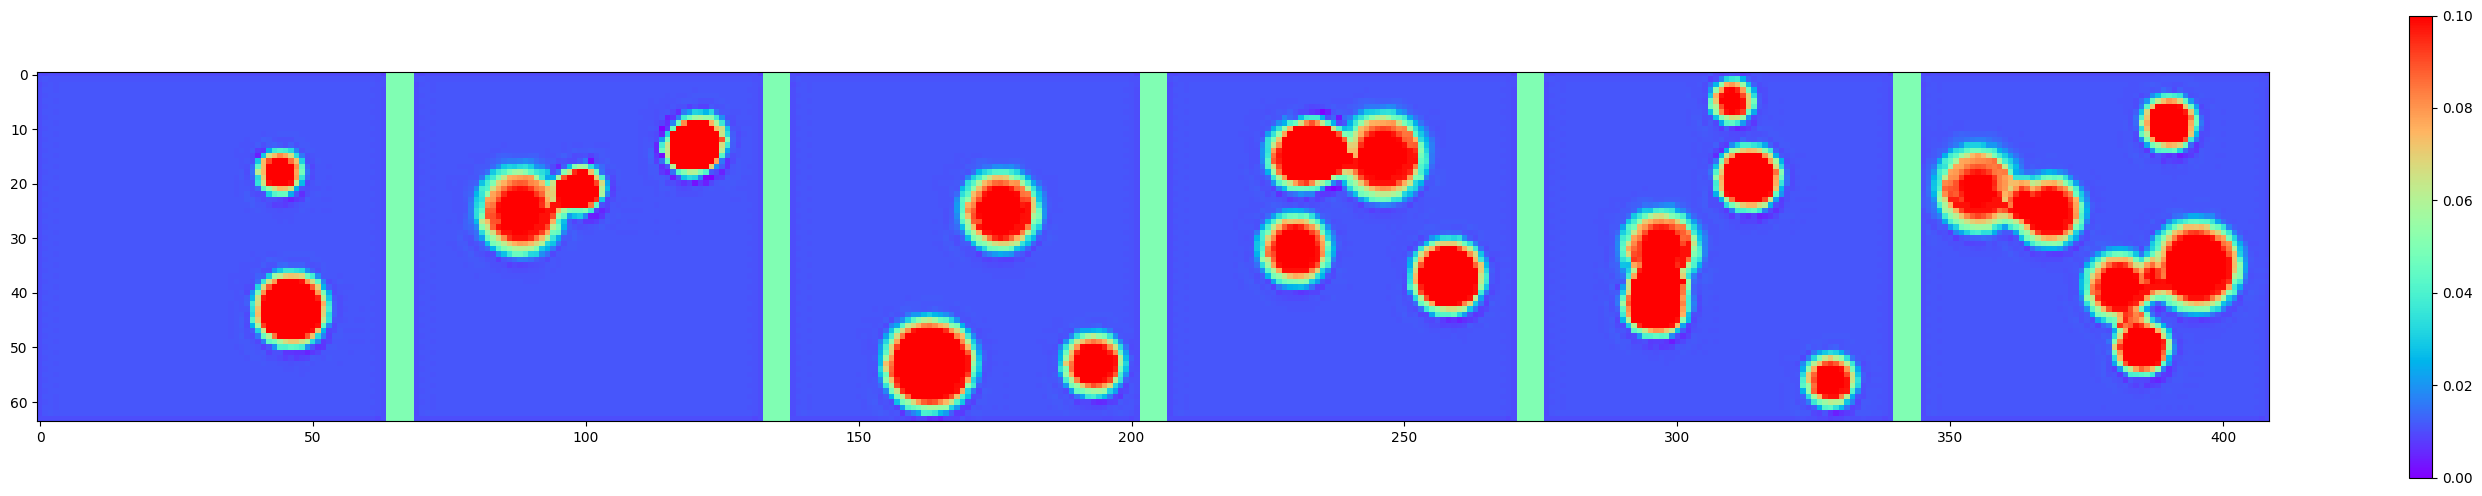

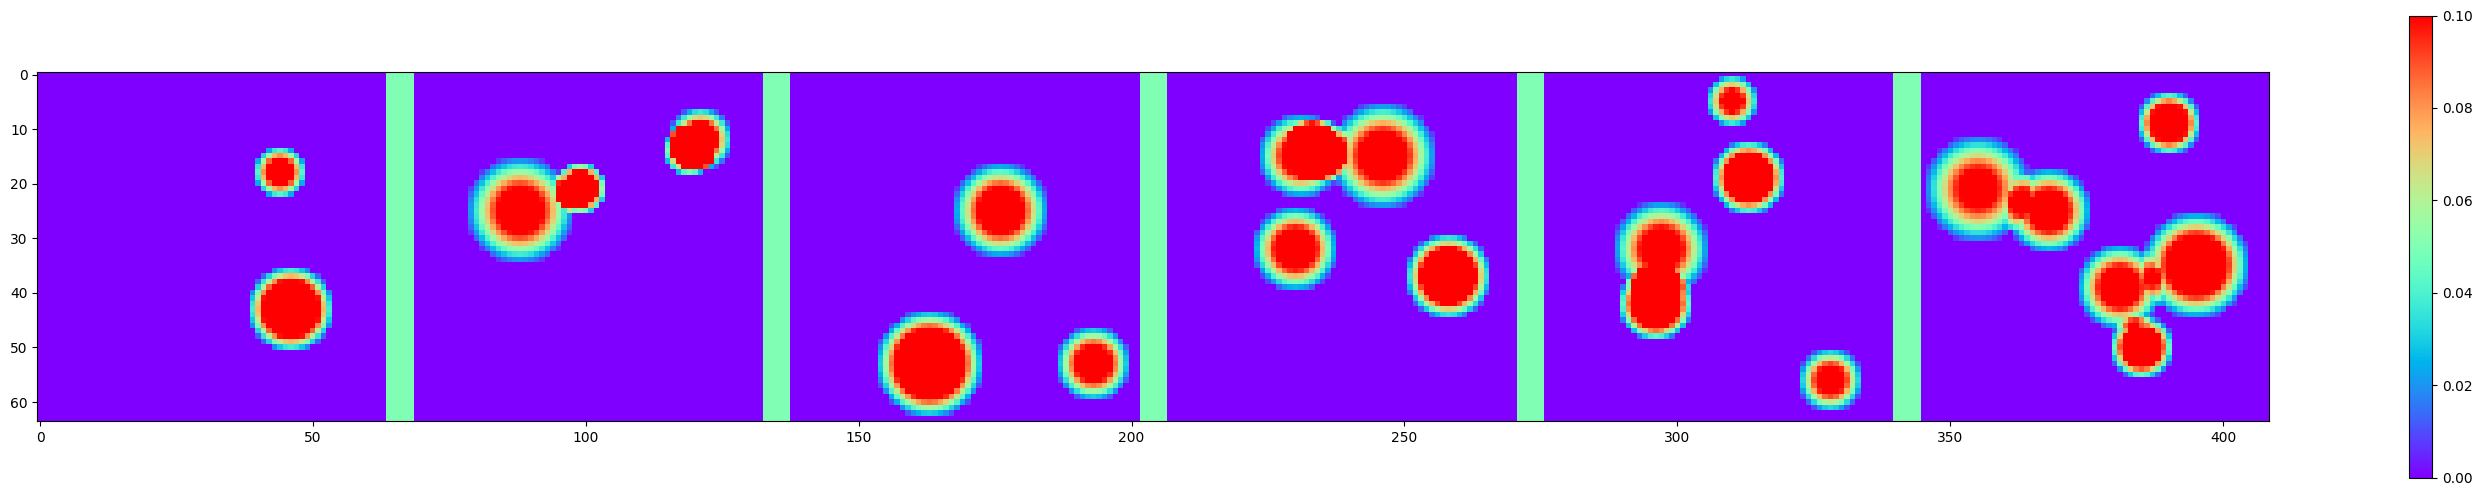

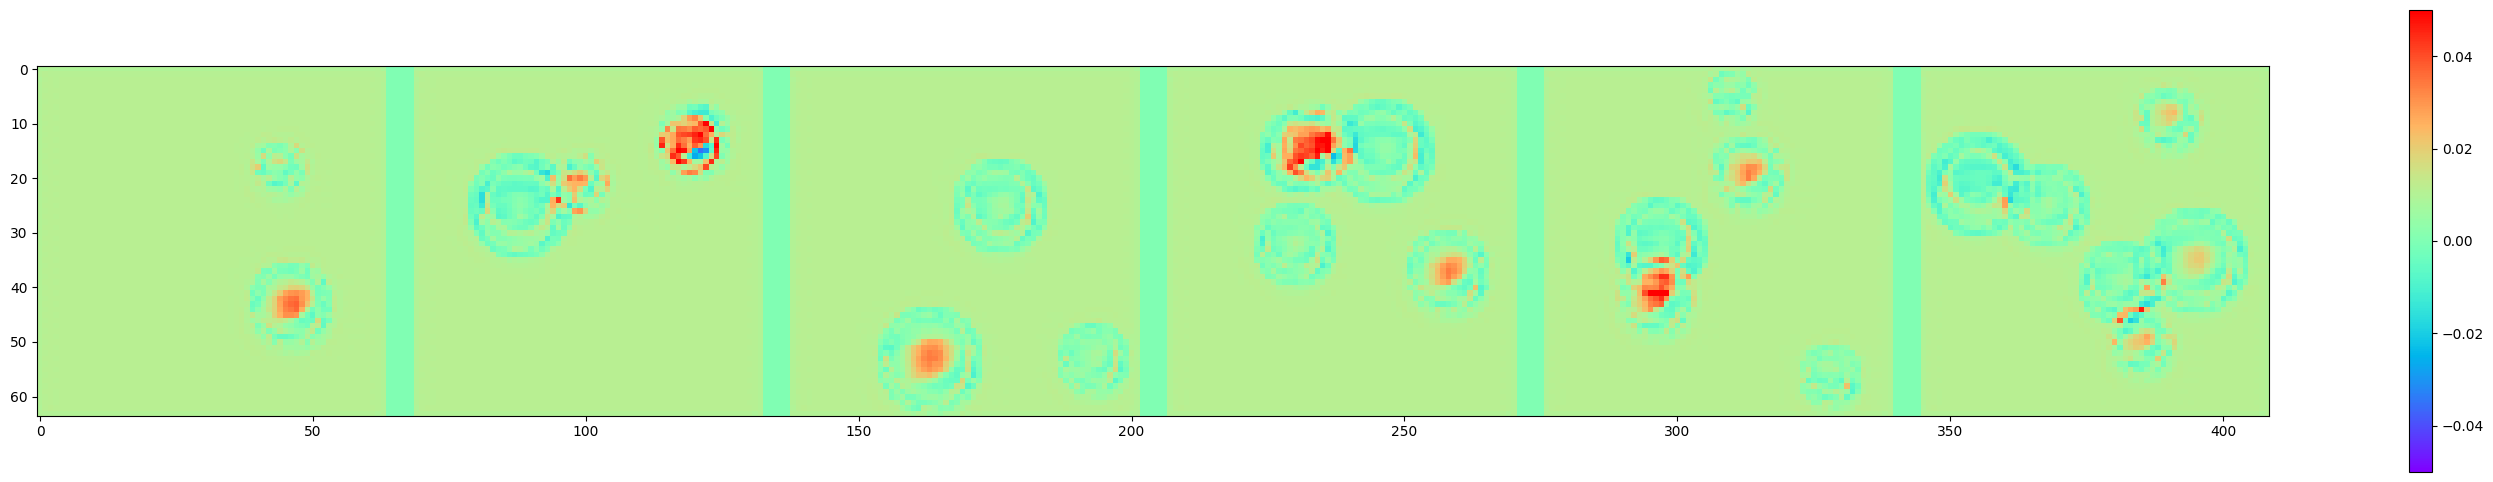

In [21]:
# viz:
fcn.eval()
input, target = gen_proba(6)
output = fcn(input.cuda())

fig = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig, k=0, min_scale=0,max_scale=1) # inputs

fig1 = plt.figure(1, figsize=(36, 6))
voir_batch2D(output.detach().cpu(), 6, fig1, k=0, min_scale=0,max_scale=0.1) # outputs

# true quantile calcul (reprise de la correction précédente)
from torch.distributions.normal import Normal
mu = input.cuda()**2
sigma = 0.2 * input.cuda() + 1e-6
dist = Normal(mu, sigma)
true_quantiles = dist.icdf(torch.tensor(0.9).cuda())

# On passe true_quantiles sur le CPU pour l'affichage et le calcul de la différence
true_quantiles_cpu = true_quantiles.detach().cpu()

fig2 = plt.figure(2, figsize=(36, 6))
voir_batch2D(true_quantiles_cpu, 6, fig2, k=0, min_scale=0.,max_scale=0.1) # ninth decile

fig3 = plt.figure(3, figsize=(36, 6))
# output.detach().cpu() et true_quantiles_cpu sont maintenant tous les deux sur CPU
voir_batch2D(output.detach().cpu() - true_quantiles_cpu, 6, fig3, k=0, min_scale=-0.05,max_scale=0.05) # outputs - ninth decile

**Exercise 2**: a trickier dependence

Let's now work with the following *gen_proba_2* function.

In [23]:
from utils_P7 import make_batch
def gen_proba_2(n):
  target1 = make_batch(n, rec = 0., noisy_rec= 0., disc = 0.0015)
  target2 = make_batch(n, rec = 0.001, noisy_rec= 0., disc = 0.)
  m = torch.normal(2, 2. + target2)
  input = target1 + target2
  target = m
  return  input, target


Here, the dependence of $y$ upon $x$ is not clearly visible in the input-target pairs:

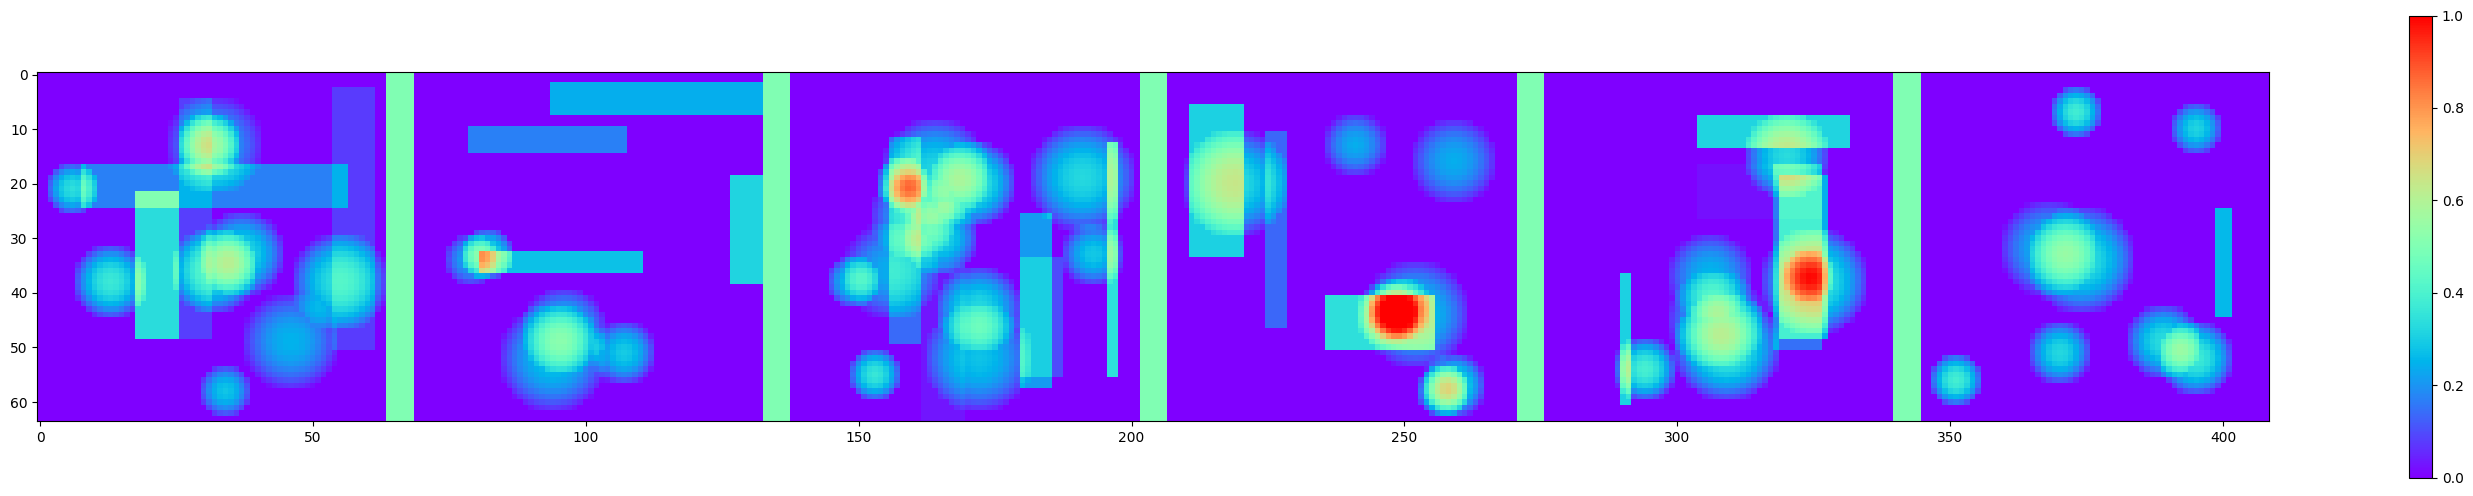

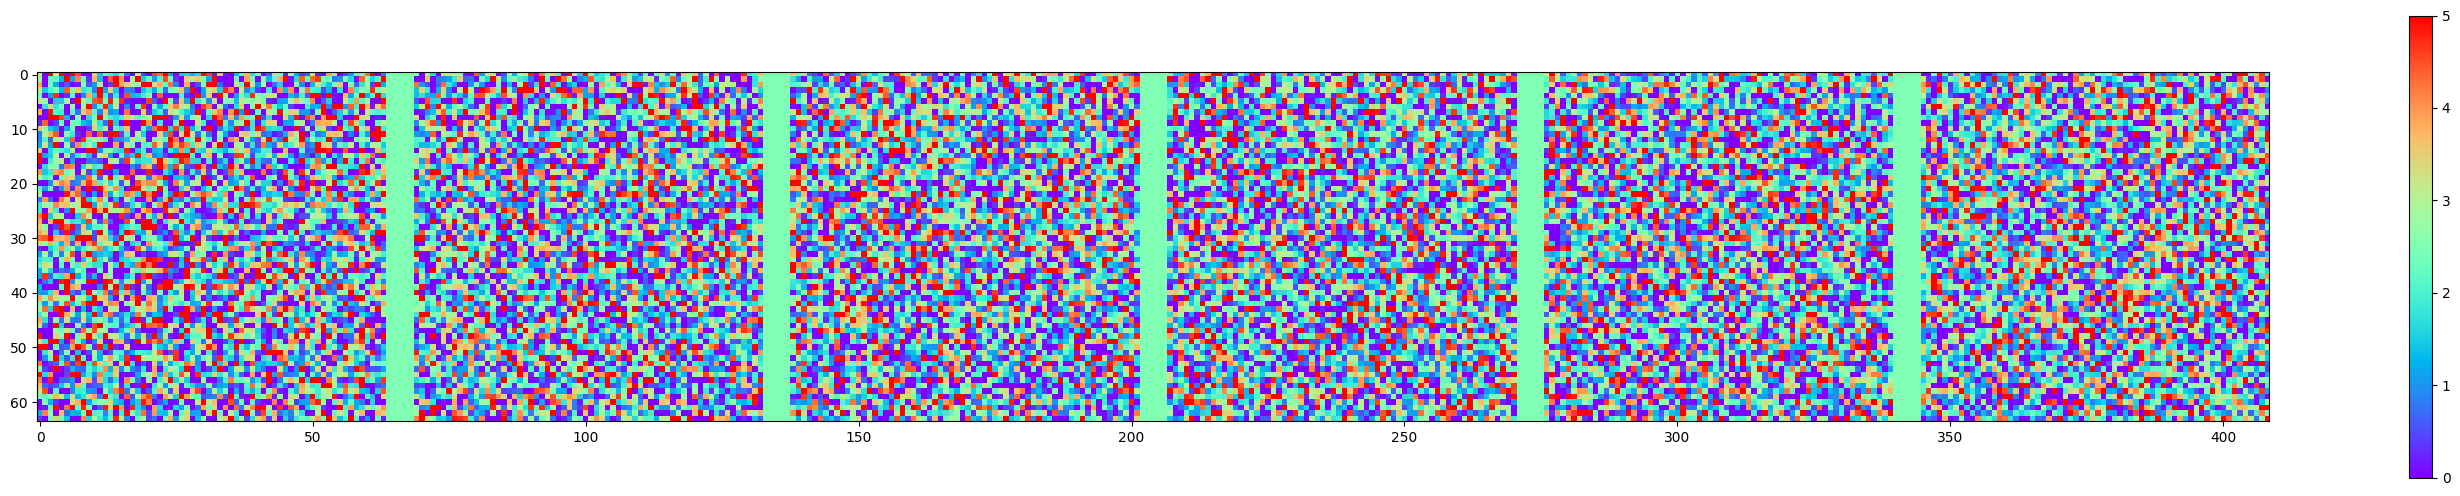

In [24]:
input, target = gen_proba_2(6)
# Inputs
fig0 = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig0, k=0, min_scale=0,max_scale=1)

# Targets
fig1 = plt.figure(1, figsize=(36, 6))
voir_batch2D(target, 6, fig1, k=0, min_scale=0,max_scale=5)

**Q1** Estimate the 0.1 quantiles of the marginal distributions and visualize the result.

In [25]:
def criterion(output, target):
  return rho(target-output, 0.1)

nepochs = 50
nbatches = 100
batchsize = 64

train_losses = []

for epoch in range(nepochs):

    print("Epoch " + str(epoch))
    epoch_losses  = []
    for i in range(nbatches):    # nbatch = datasetsize/batchsize

        # 1. Génération des données avec la nouvelle fonction gen_proba_2
        input, target = gen_proba_2(batchsize)
        input = input.cuda()
        target = target.cuda()

        # 2. Reset gradients
        optimizer.zero_grad()

        # 3. Forward
        output = fcn(input)

        # 4. Loss & Backward
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())

        epoch_losses.append(loss.detach().cpu())

        del target, input, loss
        #torch.cuda.empty_cache()

    epoch_loss = np.mean(epoch_losses)
    train_losses.append(epoch_loss)
    print('epoch loss : \n')
    print(epoch_loss)

Epoch 0


RuntimeError: grad can be implicitly created only for scalar outputs

In [ ]:
#visualisation:

fcn.eval()

input, target = gen_proba_2(6)

...

fig = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig, k=0, min_scale=0,max_scale=1)
fig1 = plt.figure(1, figsize=(36, 6))
voir_batch2D(output.detach().cpu(), 6, fig1, k=0, min_scale=-1,max_scale=0)

**Q2** Do outputs depend on inputs? Is it a pixel-wise dependence as in exercise 1? (i.e., does the distribution of $y_{i,j}$ depend only on $x_{i,j}$)



**Exercise 3**:

One can attempt to estimate $n$ quantiles simultaneously. To achieve this, the simplest way is to:

* change the number of output channels of the U-Net—e.g., 99 channels if you are estimating the $n = 100$ quantiles of orders 1%, 2%, ... 99%.
* define the overall cost function by summing individual cost functions for each of the channels.
The goal of this exercise is to code a matrix version of this overall cost function and illustrate the convergence of the learning process.


**Q1** Let $t$ be a vector of size $n-1$, and $M$ be a 4th-order tensor. Code the function: $$dot(t, M) = M^{\prime}$$ where: $$M^{\prime}_{b,i,j} = \underset{0<c<n}{\sum} t_c \times M_{b,c,i,j}$$.

This function will allow to apply $\rho_{t_c}$ (see **Exercise 1**) to each channel $c$ of the output $M$ (where $b$ represents the batch index and $i,j$ represent spatial dimensions).

In [ ]:
def dot(t, M):
	return ...

**Q2** Complete the class *QuantileLoss*:

In [ ]:
class QuantileLoss(torch.nn.Module):

    def __init__(self , n):
        super(QuantileLoss, self).__init__()
        self.n = n   # n= 100 -> centiles
        self.t = torch.arange(1/n,1,1/n).cuda()  # quantile orders

    def forward(self, output, target):
        # Ensure target has a channel dimension if it doesn't
        if target.dim() == 3:
            target = target.unsqueeze(1) # Make it (bs, 1, nx, ny)

        # Calculate the difference (error) for each channel
        # target (bs, 1, nx, ny) will broadcast to match output (bs, n-1, nx, ny)
        diff = target - output

        # Apply the rho (pinball) function. self.t (n-1) will broadcast
        # to apply the correct 't' value for each channel in 'diff'.
        rho_vals = rho(diff, self.t)

        # Sum the losses across the quantile channels (dimension 1)
        loss_by_pix = torch.sum(rho_vals, dim=1)

        # Take the mean over all remaining dimensions (batch and spatial)
        loss = torch.mean(loss_by_pix)

        return loss

**Q3** Start the training with *gen_proba* and $n=100$, then evaluate the estimation.